# Ball-and-stick model

Here we go step-by-step through the dictionary simulation for ball-and-stick.  
The ball-and-stick model follows the equation:
$$\frac{S(b,\mathbf{g})}{S(0)}=\left(1-\sum^{N}_{i=1} f_i\right)\mathrm{exp}(-bd) + \sum^{N}_{i=1} f_i \cdot \mathrm{exp}(-bd \cdot \mathbf{g}^T \mathbf{R}_i\mathbf{AR}^T_i\mathbf{g})$$

With N being the number of sticks, $f_i$ the signal fraction of the stick $i$, $d$ the diffusivity of the ball compartment,   
and $\mathbf{n_iAn_i}^T$ describes the anisotropic diffusion tensor along the i-th fiber orientation ($\theta_i, \phi_i$). $\mathbf{A}$ is a fixed matrix:
\begin{equation}
    A = \begin{bmatrix}
                1 & 0 & 0 \\
                0 & 0 & 0 \\
                0 & 0 & 0
                \end{bmatrix},
\end{equation}
and $n_i$ (the i-th stick) rotates $A$ to ($\theta_i, \phi_i$).

First we load the necessary libraries and packages

In [1]:
import laser.training.sim.dwi as dwi
from laser.utility.util import *
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import h5py
from dipy.sims import voxel
from dipy.core import gradients

Then we need to define the diffusivity values for $d$.  
We assume a diffusivity between 0.0001 and 0.003 μm²/ms. We discretize this interval  
here in `N_Diff` = 10 steps, which will act as our diffusivities.

In [2]:
N_Diff = 10
diffusivity = (0.0001    , 3E-3, N_Diff)
diffusivity_grid = dwi.get_D_linspace(diffusivity)

Then, we need to define fractions of the sticks $f_i$, defining the contribution to the signal.  
These are depedning on the number of sticks $i$. We define to use two sticks ($i = 2$).  
One stick can have a fraction between [0, 100[, while the other stick needs to be scaled  
accordingly, such that their combined sum does not reach 100 (because signal without ball is not plausible).  
We subdivide the interval in `N_steps_frac` and get in total $\sum_{i=1}^{N_{steps}} i$ possible combinations.  
So for N_steps = 5, we get 15 combinations

In [3]:
N_steps_frac = 5
stepsize = int(100/N_steps_frac)
ball_size = stepsize
fraction_array = 0
while ball_size <= 100:
    numbers = []
    num=0
    while num <= 100-ball_size:
        numbers.append(num)
        num += stepsize
    fraction_array_a = np.array(numbers)
    fraction_array_b = 100 - fraction_array_a - ball_size
    fraction_array2 = np.array((fraction_array_a, fraction_array_b)).T
    try: 
        fraction_array = np.concatenate((fraction_array, fraction_array2))
    except:
        fraction_array = fraction_array2
    ball_size += stepsize

fraction_combinations = fraction_array

The next step, is to sample again possible vectors from the unit sphere.  
These vectors are the possible values for the first and second stick.  

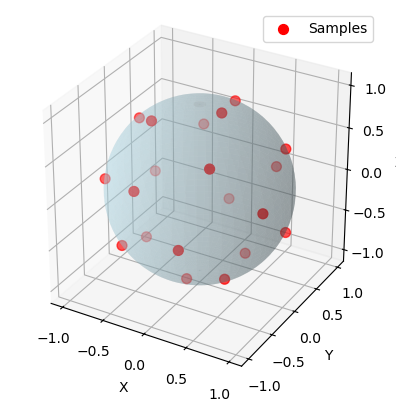

In [4]:
N_sticks = 20
angles_table = dwi.sample_from_unit_sphere(N_sticks)
plot_unit_sphere_samples(angles_table)


Then we need to get possible combinations of the two sticks, which in our definition  
is just every combination, where $Stick_1 \neq Stick_2$, therefore $N_{stick}$ x $(N_{stick} - 1)$ possible combinations
We can again plot the possible combinations:

In [ ]:
# get all possible combinations of sticks simulated in sample_from_unit_sphere
# results in N_samples x (N_samples-1) combinations
sticks_combined = []
for idx, stick1 in enumerate(angles_table):
    for idx2, stick2 in enumerate(angles_table):
        if idx == idx2:
            pass
        else:
            sticks_combined.append([stick1, stick2])

sticks_combined_slider = widgets.IntSlider(min=0, max= len(sticks_combined)-1, step=1)
sticks_combined_arr = np.array(sticks_combined)
@widgets.interact(stick_combination = sticks_combined_slider)
def interact_plots(stick_combination):
    points = sticks_combined_arr[stick_combination]
    # Create a 3D plot for the unit sphere
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot_vector(ax, points)

interactive(children=(IntSlider(value=0, description='stick_combination', max=379), Output()), _dom_classes=('…

All in all this results in $(\sum_{i=1}^{N_{stepsFrac}} i)$ x $N_{stick}$ x $(N_{stick} - 1)$ x $N_{Diff}$ signals  
which we can plot again using the sequence gradients and b-weightings

In [6]:
# load gradient directions and b-weightings of sequence
f = h5py.File('../../data/raw/1.0mm_126-dir_R3x3_dvs.h5', 'r')
bvals = f['bvals'][:]
bvecs = f['bvecs'][:]
f.close()
gtab = gradients.gradient_table_from_bvals_bvecs(bvals, bvecs, atol=3e-2)
print('Fraction combinations: ', fraction_combinations.shape[0])
print('Sticks combinations: ', len(sticks_combined))
print('Diffusivities: ', diffusivity_grid.shape[0])
print('Total number of combinations: ', diffusivity_grid.shape[0]*len(sticks_combined)*fraction_combinations.shape[0])

Fraction combinations:  15
Sticks combinations:  380
Diffusivities:  10
Total number of combinations:  57000


In [ ]:

frac_slider = widgets.IntSlider(min=0, max= fraction_combinations.shape[0]-1, step=1)
diff_slider = widgets.IntSlider(min=0, max= diffusivity_grid.shape[0]-1, step=1)
stick_comb_slider = widgets.IntSlider(min=0, max= len(sticks_combined)-1, step=1)

@widgets.interact(fraction = frac_slider, diffusivity = diff_slider, stick_combination=stick_comb_slider)
def interact_plots(fraction, diffusivity, stick_combination):
    signal_i, sticks_i = voxel.sticks_and_ball(gtab, 
                                                d=diffusivity_grid[diffusivity], 
                                                S0=1., 
                                                angles=sticks_combined[stick_combination], 
                                                fractions=fraction_combinations[fraction], 
                                                snr=None)
    
    fig = plt.figure(figsize=(10, 4))
    ax1 = fig.add_subplot(121)
    ax1.plot(signal_i)
    ax1.set_title('Resulting signal')
    ax1.set_yticks([0,0.5,1])
    param_text = (
        f"Fractions: {fraction_combinations[fraction][0]:.0f}; {fraction_combinations[fraction][1]:.0f}\n"
        f"Diffusivity: {diffusivity_grid[diffusivity]:.4f} μm²/ms\n"
        f"Stick Combination Index: {stick_combination}"
    )
    ax1.text(2.3, 0.9, s=param_text, transform=ax1.transAxes, fontsize=12, verticalalignment='center')
    

    points = sticks_combined_arr[stick_combination]
    # Create a 3D plot for the unit sphere
    ax2 = fig.add_subplot(122, projection='3d')
    plot_vector(ax2, points)
    ax2.set_title('Stick directions')

interactive(children=(IntSlider(value=0, description='fraction', max=14), IntSlider(value=0, description='diff…

And finally, we add Gaussian noise with different standard deviations to these signals.  
By that we create a dataset for training N_std times the size of the original dataset.  
Let's look at the noisy signals now compared to the clean signals:

In [8]:
N_std = 8

frac_slider = widgets.IntSlider(min=0, max= fraction_combinations.shape[0]-1, step=1)
diff_slider = widgets.IntSlider(min=0, max= diffusivity_grid.shape[0]-1, step=1)
stick_comb_slider = widgets.IntSlider(min=0, max= len(sticks_combined)-1, step=1)
std_slider = widgets.IntSlider(min=0, max= N_std-1, step=1)

@widgets.interact(fraction = frac_slider, diffusivity = diff_slider, stick_combination=stick_comb_slider, std_idx= std_slider)
def interact_plots(fraction, diffusivity, stick_combination, std_idx):
    signal_i, sticks_i = voxel.sticks_and_ball(gtab, 
                                                d=diffusivity_grid[diffusivity], 
                                                S0=1., 
                                                angles=sticks_combined[stick_combination], 
                                                fractions=fraction_combinations[fraction], 
                                                snr=None)

    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(121)
    plt.plot(signal_i)
    plt.title('Clean signal')
    plt.yticks([0,0.5,1])
    param_text = (
        f"Fractions: {fraction_combinations[fraction][0]:.0f}; {fraction_combinations[fraction][1]:.0f}\n"
        f"Diffusivity: {diffusivity_grid[diffusivity]:.4f} μm²/ms\n"
        f"Stick Combination Index: {stick_combination}"
    )
    ax1.text(2.3, 0.9, s=param_text, transform=ax1.transAxes, fontsize=12, verticalalignment='center')
    
    plt.subplot(122)

    if std_idx > 0:
        std = 0.01 + std_idx * 0.03
    else:
        std = 0
    noisy_sig = add_noise(signal_i, std, noiseType = 'gaussian')
    plt.plot(noisy_sig)
    plt.title('Signal noise std = ' + str(np.round(std, 4)))
    plt.yticks([0,0.5,1])
    

interactive(children=(IntSlider(value=0, description='fraction', max=14), IntSlider(value=0, description='diff…

These signals can then be used to train the DAE to denoise diffusion signals as implemented in `laser/training/train.py`